In [42]:
import pandas as pd

Taking only 2 columns from each dataset and concatenating everything to obtain final dataframe of size 162110 rows x 2 columns - the content of the message (either SMS or email) & label (spam or ham)
Note: error when pd.read_csv TREC_05.csv & TREC_06.csv but TREC_07.csv is fine

In [ ]:
df = pd.read_csv("./../data/raw/emails.csv")
df['body'] = df['text']
df['label'] = df['spam']
df1 = df[['body', 'label']]

In [ ]:
df = pd.read_csv("./../data/raw/spam_ham_dataset.csv")
df['body'] = df['text']
df['label'] = df['label_num']
df2 = df[['body', 'label']]

In [ ]:
df = pd.read_csv("./../data/raw/SMSSpamCollection.tsv", sep='\t', header=None, names=['label_name', 'body'])
df['label'] = df['label_name'].map({'spam': 1, 'ham': 0})
df3 = df[['body', 'label']]

In [50]:
df = pd.concat([df1,df2,df3], ignore_index=True)

In [51]:
lst_standard_datasets = ["CEAS_08.csv", "Enron.csv", "Ling.csv", "Nazario.csv", "Nazario_5.csv", "Nigerian_5.csv", "Nigerian_Fraud.csv", "SpamAssasin.csv", "TREC_07.csv"]

In [52]:
for dataset in lst_standard_datasets:
    df = pd.concat([df, pd.read_csv("./../data/raw/"+dataset)[['body','label']]], ignore_index=True)

In [55]:
df.info

<bound method DataFrame.info of                                                      body  label
0       Subject: naturally irresistible your corporate...      1
1       Subject: the stock trading gunslinger  fanny i...      1
2       Subject: unbelievable new homes made easy  im ...      1
3       Subject: 4 color printing special  request add...      1
4       Subject: do not have money , get software cds ...      1
...                                                   ...    ...
162105  \n\n\n\nWhile      we  may       have    high ...      1
162106  \n\n\n\nWhile     we       may    have high   ...      1
162107  For those who are interested, I just cook a li...      0
162108  Hello,\n\nas I wrote I call\n\n  sqlFetch(chan...      0
162109  Well, are implicated.  When does not the stage...      1

[162110 rows x 2 columns]>

In [57]:
df['label'].value_counts() #roughly same proportion of spam & non-spam

label
0    81309
1    80801
Name: count, dtype: int64

PREPROCESS TO DO EDA

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
#Preprocess
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    '''
    1. lowercase
    2. remove links & numbers & "\n" & "Subject:" related words at the start of the sentence
    3. tokenize
    4. remove stopwards
    5. lemmatize
    '''

    # Ensure correct data type
    text = str(text) 

    # Lowercasing
    text = text.lower()
    
    # Remove special characters, links, and numbers
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only alphabets and spaces
    text = re.sub("\n", " ", text) # Remove new line indicator
    text = re.sub(r"^(Subject: re :|Subject:)\s*", "", text) # Remove repetitive words
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

# Apply preprocessing
df['tokens'] = df['body'].apply(preprocess)
    

In [ ]:
nltk.download('all')

In [63]:
from gensim.models import Word2Vec


To analyse semantics of the texts!
Hypothesis: 
Certain words may be consistently used differently in spam & non-spam context. 
For example, we expect that the w2v model trained on only spam will use the word "free" in the sense of obtaining goods without any monetary cost, while the w2v model for non-spam will use the word "free" in another meaning, such as referring to whether a person is available at a particular time period.
Additionally, the w2v model trained on spam will use the word "claim" in the context of obtaining an exclusive item or large sum of money, while the w2v model trained on non-spam will use the word "claim" in other ways, possibly with the meaning of making an assumption or any other meaning.

Try split into spam & non-spam to see if any difference. Slight issue with misspelled words 

In [ ]:
# Train Word2Vec model on spam
df_spam = df[df['label'] == 1]
w2v_model_spam = Word2Vec(sentences=df_spam['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Check vocabulary size
print("Vocabulary Size:", len(w2v_model_spam.wv))

Vocabulary Size: 322917


In [ ]:
# Train Word2Vec model on non-spam
df_nonspam = df[df['label'] == 0]
w2v_model_nonspam = Word2Vec(sentences=df_nonspam['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Check vocabulary size
print("Vocabulary Size:", len(w2v_model_nonspam.wv))

Vocabulary Size: 334318


In [66]:
# Find words most similar to "free". see if there's any difference
print(w2v_model_spam.wv.most_similar("free"))
print(w2v_model_nonspam.wv.most_similar("free"))

[('guide', 0.5767554640769958), ('complimentary', 0.5651521682739258), ('plus', 0.5603089928627014), ('namebrand', 0.5228765606880188), ('today', 0.5184181332588196), ('included', 0.49299702048301697), ('package', 0.488118976354599), ('freeyour', 0.48710736632347107), ('disbarred', 0.48627376556396484), ('learn', 0.48574286699295044)]
[('piggish', 0.5265879034996033), ('geldbach', 0.516151487827301), ('reward', 0.5087076425552368), ('laggy', 0.4914794862270355), ('bulletinboards', 0.48691239953041077), ('topcn', 0.48507383465766907), ('complimentary', 0.4796687662601471), ('ourselveshow', 0.4792914092540741), ('forsaken', 0.46913251280784607), ('encombrante', 0.464615136384964)]


In [69]:
print(w2v_model_spam.wv.most_similar("reward"))
print(w2v_model_nonspam.wv.most_similar("reward"))

[('ontrack', 0.5540139079093933), ('participate', 0.546155571937561), ('reap', 0.5445781946182251), ('thankyousm', 0.5441350340843201), ('loginor', 0.5205991268157959), ('viiiiiagraa', 0.5006282925605774), ('reaps', 0.49973219633102417), ('follow', 0.4899892807006836), ('financially', 0.4734869599342346), ('giveaway', 0.47239962220191956)]
[('benefit', 0.6690506339073181), ('earn', 0.615550696849823), ('learn', 0.6092889308929443), ('investing', 0.6059517860412598), ('employer', 0.5970974564552307), ('discover', 0.5937449932098389), ('opportunity', 0.5848253965377808), ('mutual', 0.5794070959091187), ('traveler', 0.5781325101852417), ('pension', 0.5780474543571472)]


In [70]:
print(w2v_model_spam.wv.most_similar("prize"))
print(w2v_model_nonspam.wv.most_similar("prize"))

[('winning', 0.7982379794120789), ('congratulation', 0.7113587856292725), ('eguyis', 0.6982656121253967), ('winner', 0.6809620261192322), ('uros', 0.6590266823768616), ('oles', 0.6445715427398682), ('lottery', 0.6262789368629456), ('notarized', 0.6215111613273621), ('lucky', 0.6095642447471619), ('scand', 0.5996264219284058)]
[('award', 0.7646884322166443), ('winner', 0.7597923278808594), ('contest', 0.723528265953064), ('prestigious', 0.7130646705627441), ('winning', 0.6651513576507568), ('untenured', 0.6296520233154297), ('nobel', 0.6295121312141418), ('bonus', 0.6145668625831604), ('tournament', 0.6142895221710205), ('grand', 0.6127691268920898)]


In [71]:
print(w2v_model_spam.wv.most_similar("claim"))
print(w2v_model_nonspam.wv.most_similar("claim"))

[('beneficiary', 0.5757323503494263), ('authority', 0.5435113310813904), ('documentation', 0.5423892736434937), ('verification', 0.5118783116340637), ('inheritance', 0.5097403526306152), ('collect', 0.5049138069152832), ('confirmed', 0.5024895668029785), ('release', 0.4995678663253784), ('ownership', 0.47615310549736023), ('judgment', 0.4709034562110901)]
[('appeal', 0.7196396589279175), ('alleged', 0.6842384934425354), ('claimed', 0.6818739175796509), ('lawsuit', 0.6798754930496216), ('criminal', 0.6780682802200317), ('complaint', 0.6761260032653809), ('discrimination', 0.6754841804504395), ('threatening', 0.6671445965766907), ('riaa', 0.6647290587425232), ('argues', 0.6485704779624939)]


Visualize. Can try other `target_word` as well

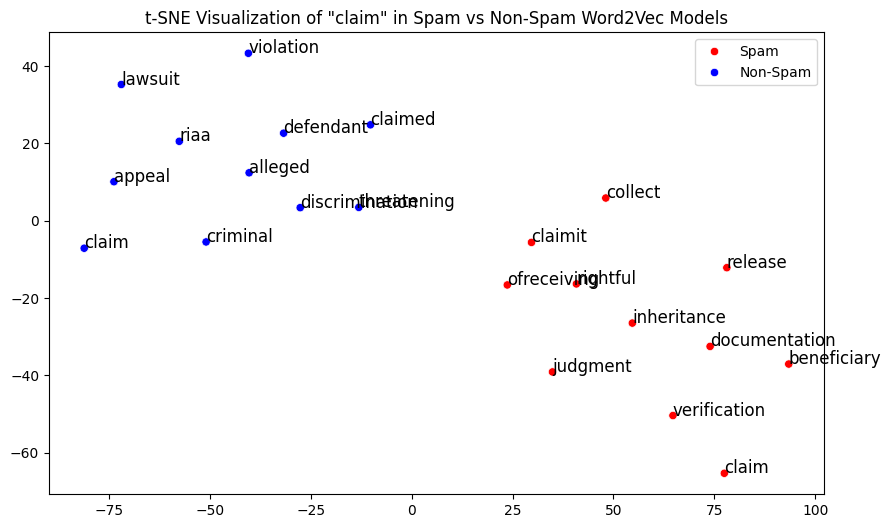

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Define words to visualize
target_word = "claim"
words_spam = [word for word, _ in w2v_model_spam.wv.most_similar(target_word, topn=10)]
words_non_spam = [word for word, _ in w2v_model_nonspam.wv.most_similar(target_word, topn=10)]

# Get vectors from both models
words = [target_word] + words_spam + [target_word] + words_non_spam
vectors = [w2v_model_spam.wv[word] for word in [target_word] + words_spam] + \
          [w2v_model_nonspam.wv[word] for word in [target_word] + words_non_spam]

# Convert to NumPy array
vectors = np.array(vectors)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Ensure labels match the number of points
labels = ['Spam'] * (len(words_spam) + 1) + ['Non-Spam'] * (len(words_non_spam) + 1)

# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=labels, palette={'Spam': 'red', 'Non-Spam': 'blue'})

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.title(f't-SNE Visualization of "{target_word}" in Spam vs Non-Spam Word2Vec Models')
plt.show()


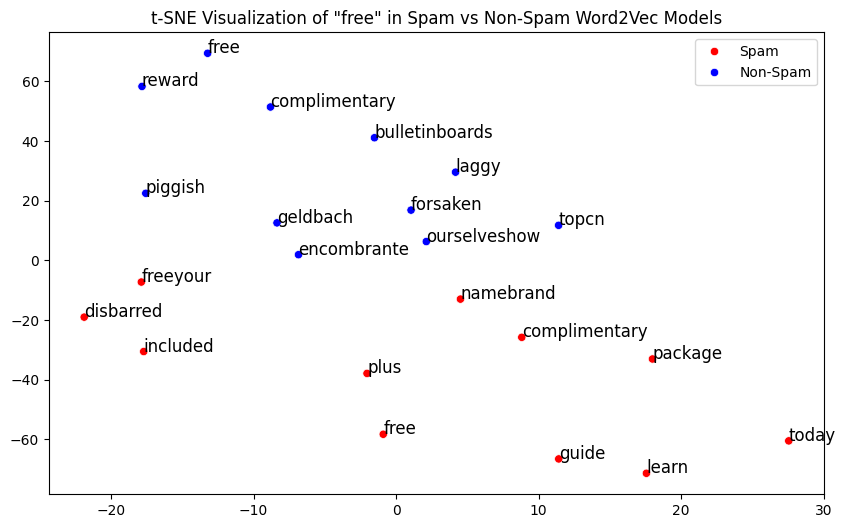

In [72]:
# Define words to visualize
target_word = "free"
words_spam = [word for word, _ in w2v_model_spam.wv.most_similar(target_word, topn=10)]
words_non_spam = [word for word, _ in w2v_model_nonspam.wv.most_similar(target_word, topn=10)]

# Get vectors from both models
words = [target_word] + words_spam + [target_word] + words_non_spam
vectors = [w2v_model_spam.wv[word] for word in [target_word] + words_spam] + \
          [w2v_model_nonspam.wv[word] for word in [target_word] + words_non_spam]

# Convert to NumPy array
vectors = np.array(vectors)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Ensure labels match the number of points
labels = ['Spam'] * (len(words_spam) + 1) + ['Non-Spam'] * (len(words_non_spam) + 1)

# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=labels, palette={'Spam': 'red', 'Non-Spam': 'blue'})

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.title(f't-SNE Visualization of "{target_word}" in Spam vs Non-Spam Word2Vec Models')
plt.show()